<h1 align=center> Restaurant Recommendation System </h1>

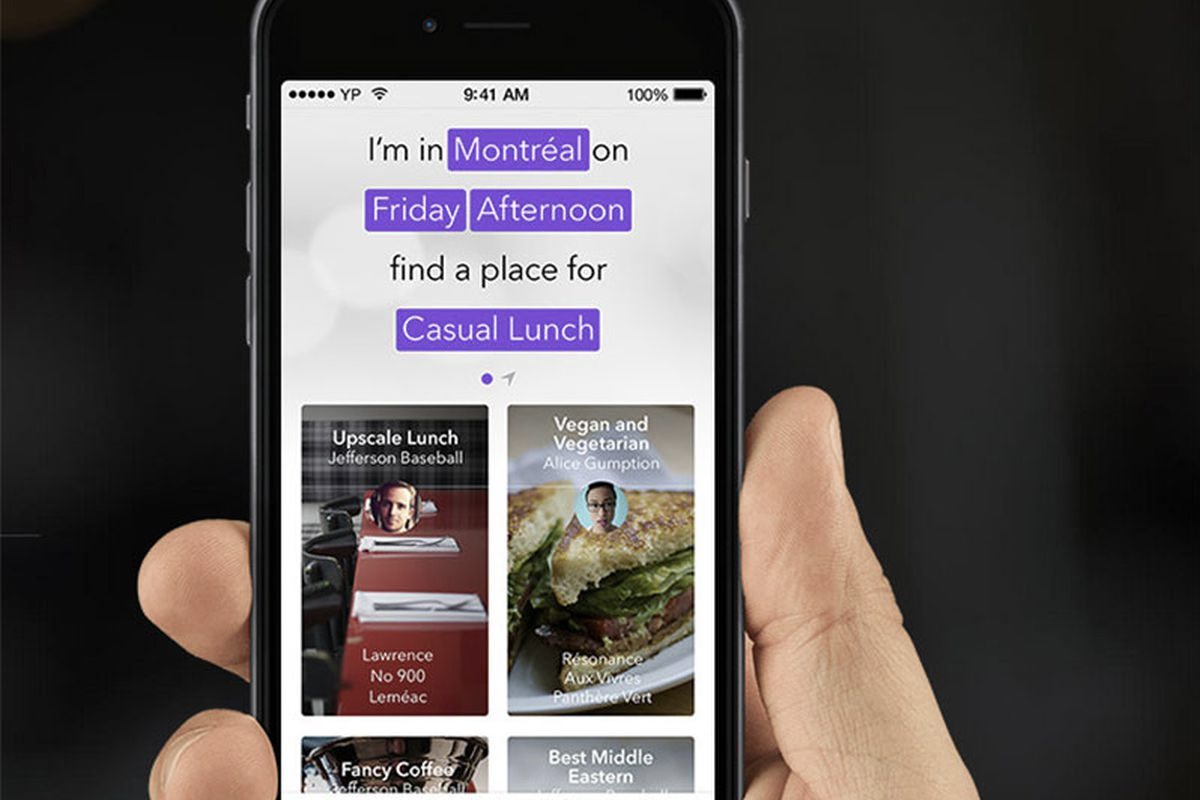



### Brief about the DataSet and the Model :

Restaurant Recommendation System : Often times, when we want to visit a restaurant either for a casual lunch or Dinner or for the Party, we have an ambiguity about the restaurants and infact most of the times, we would be unaware of the restaurants around. Hence in this ML model, we have developed a recommendation system, which would recommend a user about the restaurants of similar taste, which he hasn't visited yet. We have also created another model, which provides the recommendation based on user input preferences, For ex :- if a user wants "Indian restaurants", then he can just input this text to model and then you have the list of top 10 recommendations.

<hr>

This Dataset is taken from Kaggle :- https://www.kaggle.com/mobasshir/yelpdata 

<b> More about the Dataset : </b>
1. <b><i>yelp_business.csv</i></b> :- This CSV would contain all the information related to the Restaurant, where each restaurant has been assigned an unique business_id along with it, it has complete information about the restaurant like its address, stars, review count, longitude and latitude, review comments.
<hr>

2. <b><i>yelp_review_Arizona.csv </i></b>:- This CSV could contain an information about the user/customer who has visited this restaurant in past and have provided some review about that restaurant and also some rating with review comments.

<b><i><u>#### Note :- Since the data is more than 25MB, this couldn't be uploaded to github and hence have used Google Drive to store the data and access the same below. However, since the google drive access through Google colab would need the Google Auth code, 3rd parties cannot access the data and hence you may need to download the data and use them accordingly, else you can store it your drive and access the same as shown below.

#### Another reason for using Google COlab is that, the tfidf vectorization for teh review text and also the Stochastic GD calc below is takign huge time and compute resource and hence its recommended to run this notebook in Google colab rather than your laptop or system. </u></i></b>

<p style="color:red; font-size:150%; font-family:courier;">Please run the below code on Google Colab</p>
    


 

### List of Top Rated restaurants

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer

In [112]:
!pip install -U -q PyDrive

In [113]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth
from oauth2client.client import GoogleCredentials 

In [114]:
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [115]:
link = "https://drive.google.com/file/d/1Yt1Cf3RIpd7GR8qdaxpLdWcqiRYsXA8s/view?usp=sharing"
id = link.split("/")[-2] 
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('yelp_review_Arizona.csv')
data_users = pd.read_csv('yelp_review_Arizona.csv')

In [116]:
link = "https://drive.google.com/file/d/1qa5fibEn6KbGljUGc7ah451fi7XMdDAy/view?usp=sharing"
id = link.split("/")[-2] 
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('yelp_business.csv')
data_restaurant = pd.read_csv('yelp_business.csv')

In [117]:
#data_users=pd.read_csv('/Users/sukshe01/Desktop/Desktop/INSAID/Projects/Restaurant_Recommendation_System/Kaggle_Dataset/yelp_review_arizona.csv')
#data_restaurant=pd.read_csv('/Users/sukshe01/Desktop/Desktop/INSAID/Projects/Restaurant_Recommendation_System/Kaggle_Dataset/yelp_business.csv')

In [118]:
data_users.head()

,review_id,user_id,business_id,text,stars,date
0,V93SYj2OLh5m9Cquzf-7kg,ZwVz20be-hOZnyAbevyMyQ,2c9Vptks_vowLgVUMnCgjw,Came here while in town for a country concert....,4.0,2013-09-04 01:29:46
1,vNTFadc6T9HeH3Qa78dc_Q,91TB-gzcNyxFh46TL0pmnQ,6nKR80xEGHYf2UxAe_Cu_g,Best barbecue this side of the Mississippi!!!!...,5.0,2015-12-05 02:50:10
2,SXRFBCt5eXCBF7TlI7UG6Q,Y_QBiZpATJoz8hKUfYF66A,fbQaKW0Lte0JQ_opbnjdKg,Absolutely amazing. Think Chipotle for enchila...,5.0,2014-04-01 01:56:00
3,CqMNjtG0hNZGhDw4RDE-zw,_Jg-IA0M-GSjBlGu-wmejg,r8764MtYyt8JhxMvrfM_xQ,I was really disappointed with my most recent ...,2.0,2014-10-11 03:53:53
4,5hZLouGEW4wm6BTJ5aNUNw,1CqkFliipv_X15WYn5aPfg,QS3QxI7u5PRdtbGgI0-UsA,I grade sushi restaurants on 3 factors:\n- Qua...,4.0,2015-03-04 19:36:21


In [119]:
data_restaurant.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,NaN,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [120]:
## Let's check if there are any Missing values?
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26606 entries, 0 to 26605
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    26606 non-null  object 
 1   user_id      26606 non-null  object 
 2   business_id  26606 non-null  object 
 3   text         26606 non-null  object 
 4   stars        26606 non-null  float64
 5   date         26606 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.2+ MB


##### There are no missing values in this dateset.

In [121]:
##Let's extract just the year of the visit/rating by the user for various restaurants
import datetime
data_users['date']=pd.DatetimeIndex(data_users['date']).year

In [122]:
data_users.head()

,review_id,user_id,business_id,text,stars,date
0,V93SYj2OLh5m9Cquzf-7kg,ZwVz20be-hOZnyAbevyMyQ,2c9Vptks_vowLgVUMnCgjw,Came here while in town for a country concert....,4.0,2013
1,vNTFadc6T9HeH3Qa78dc_Q,91TB-gzcNyxFh46TL0pmnQ,6nKR80xEGHYf2UxAe_Cu_g,Best barbecue this side of the Mississippi!!!!...,5.0,2015
2,SXRFBCt5eXCBF7TlI7UG6Q,Y_QBiZpATJoz8hKUfYF66A,fbQaKW0Lte0JQ_opbnjdKg,Absolutely amazing. Think Chipotle for enchila...,5.0,2014
3,CqMNjtG0hNZGhDw4RDE-zw,_Jg-IA0M-GSjBlGu-wmejg,r8764MtYyt8JhxMvrfM_xQ,I was really disappointed with my most recent ...,2.0,2014
4,5hZLouGEW4wm6BTJ5aNUNw,1CqkFliipv_X15WYn5aPfg,QS3QxI7u5PRdtbGgI0-UsA,I grade sushi restaurants on 3 factors:\n- Qua...,4.0,2015


In [123]:
data_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   192609 non-null  object 
 1   name          192609 non-null  object 
 2   address       184927 non-null  object 
 3   city          192608 non-null  object 
 4   state         192609 non-null  object 
 5   postal_code   191950 non-null  object 
 6   latitude      192609 non-null  float64
 7   longitude     192609 non-null  float64
 8   stars         192609 non-null  float64
 9   review_count  192609 non-null  int64  
 10  is_open       192609 non-null  int64  
 11  attributes    163773 non-null  object 
 12  categories    192127 non-null  object 
 13  hours         147779 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB


###### Attributes like "attributes", "categories" and "hours" have some missing values, however these doesn't contribute to our Model construction. Hence we would ignore the same.

### Let's check out the top rated restaurants

In [124]:
#top_rest_list=[]
#top_rating_list=[]
#for i in range(10):
#    print(data_restaurant.loc[data_restaurant['business_id']==data_users.groupby(['business_id'])['stars'].mean().sort_values(ascending=False)[0:10].reset_index().iloc[i,0]]['name'].iloc[0])
#    top_rest_list.append(data_restaurant.loc[data_restaurant['business_id']==data_users.groupby(['business_id'])['stars'].mean().sort_values(ascending=False)[0:10].reset_index().iloc[i,0]]['name'].iloc[0])
#    print("Avg. Rating = ", data_users.groupby(['business_id'])['stars'].mean().sort_values(ascending=False).iloc[i])
#    top_rating_list.append(data_users.groupby(['business_id'])['stars'].mean().sort_values(ascending=False).iloc[i])

In [125]:
top_5_bus_id_list=data_users.groupby('business_id')['user_id'].count().sort_values(ascending=False).iloc[0:10]
top_5_bus_id_list.index

Index(['OgJ0KxwJcJ9R5bUK0ixCbg', '9a3DrZvpYxVs3k_qwlCNSw',
       'JzOp695tclcNCNMuBl7oxA', 'k1QpHAkzKTrFYfk6u--VgQ',
       'cTJjTKz2huGZ-ElScC2pSw', 'z6-reuC5BYf_Rth9gMBfgQ',
       'wl0QZqAzr1DelslQ02JGCQ', 'pSQFynH1VxkfSmehRXlZWw',
       'VyVIneSU7XAWgMBllI6LnQ', '3l54GTr8-E3XPbIxnF_sAA'],
      dtype='object', name='business_id')

#### Below are the top 10 restaurants sorted by Avg. user rating

In [126]:
top_rest_list_1=[]
top_rating_list_1=[]
for items in top_5_bus_id_list.index:
    print(data_restaurant.loc[data_restaurant['business_id']==items]['name'].iloc[0])
    top_rest_list_1.append(data_restaurant.loc[data_restaurant['business_id']==items]['name'].iloc[0])
    print("Avg Rating = ",data_users.loc[data_users['business_id']==items]['stars'].mean())
    print("\n")
    top_rating_list_1.append(data_users.loc[data_users['business_id']==items]['stars'].mean())

Lux Central
Avg Rating =  4.256410256410256


Cibo
Avg Rating =  4.316831683168317


Four Peaks Brewing
Avg Rating =  4.175257731958763


The Parlor
Avg Rating =  4.222222222222222


Windsor
Avg Rating =  4.089887640449438


St. Francis Restaurant
Avg Rating =  3.848101265822785


Cornish Pasty
Avg Rating =  4.226666666666667


Pizzeria Bianco
Avg Rating =  3.7534246575342465


Bobby Q
Avg Rating =  4.47945205479452


Rehab Burger Therapy
Avg Rating =  4.180555555555555




In [127]:
#top_rating_list_1.sort()

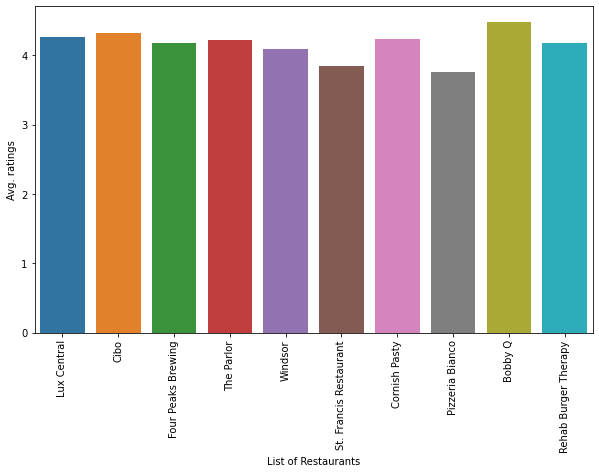

In [128]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
plt.xlabel("List of Restaurants")
plt.ylabel("Avg. ratings")
bar=sns.barplot(x=top_rest_list_1,y=top_rating_list_1,orient='v')

##### Assuming from the Dataset that most of the restaurants have been covered in this list for a given city and state. Let's check the number of restaurants that has been there in each state.

In [129]:
data_restaurant.groupby(['city'])['state'].count().sort_values(ascending=False)

city
Las Vegas        29370
Toronto          18906
Phoenix          18766
Charlotte         9509
Scottsdale        8837
                 ...  
Nevada               1
Nellis               1
Nationwide           1
NORTH YORK           1
110 Las Vegas        1
Name: state, Length: 1203, dtype: int64

In [130]:
from nltk.corpus import stopwords
import string

def remove_stop_words(df):
    no_punc = [char for char in df if char not in string.punctuation]

    no_punc = ''.join(no_punc)
    
    return " ".join([word for word in no_punc.split() if word.lower() not in stopwords.words('english')])

In [131]:
#data_users['text']=data_users['text'].apply(remove_stop_words)

In [132]:
top_rest_list_1

['Lux Central',
 'Cibo',
 'Four Peaks Brewing',
 'The Parlor',
 'Windsor',
 'St. Francis Restaurant',
 'Cornish Pasty',
 'Pizzeria Bianco',
 'Bobby Q',
 'Rehab Burger Therapy']

In [133]:
data_restaurant.loc[data_restaurant['name']=='Lux Central']

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
99510,OgJ0KxwJcJ9R5bUK0ixCbg,Lux Central,4400 N Central Ave,Phoenix,AZ,85012,33.500597,-112.074237,4.5,2046,1,"{'RestaurantsPriceRange2': '2', 'WiFi': ""'free...","Bakeries, American (New), Nightlife, Bars, Cof...","{'Monday': '6:0-0:0', 'Tuesday': '6:0-0:0', 'W..."


### Below mentioned are the categories of the Top 10 restaurants.

In [134]:
category_list=[]
for rest in top_rest_list_1:
    print("Categories in \"{0}\" restaurant are : {1} \n".format(rest,data_restaurant.loc[data_restaurant['name']==rest]['categories'].iloc[0]))
    category_list.append(data_restaurant.loc[data_restaurant['name']==rest]['categories'].iloc[0])

Categories in "Lux Central" restaurant are : Bakeries, American (New), Nightlife, Bars, Coffee & Tea, Restaurants, Breakfast & Brunch, Food 

Categories in "Cibo" restaurant are : Italian, Canadian (New), Food, American (New), Restaurants 

Categories in "Four Peaks Brewing" restaurant are : Sandwiches, Food, Burgers, Restaurants, American (New), Specialty Food, Breakfast & Brunch, Breweries, Pizza, Nightlife, Bars, Pubs, Cheese Shops 

Categories in "The Parlor" restaurant are : Salad, Italian, Sandwiches, Pizza, Restaurants 

Categories in "Windsor" restaurant are : Women's Clothing, Formal Wear, Fashion, Shopping, Accessories 

Categories in "St. Francis Restaurant" restaurant are : Salad, Restaurants, Food, Breakfast & Brunch, Desserts, American (New) 

Categories in "Cornish Pasty" restaurant are : Nightlife, Pubs, British, Bars, Restaurants 

Categories in "Pizzeria Bianco" restaurant are : Tapas/Small Plates, Italian, Pizza, Restaurants 

Categories in "Bobby Q" restaurant are :

In [135]:
str_dict=dict()
ind_list=[]
count=0
for cate in category_list:
    #print(cate)
    ind_list.append(str(cate).split(','))

#print(ind_list)
for lst in ind_list:
    for items in lst:
        if items in str_dict.keys():
            count=count+1
            str_dict.update({items:count})
        else:
            str_dict.update({items:count+1})
    #str_dict.update({:})
    

In [136]:
#print(sorted(str_dict,key=str_dict.get,reverse=True))
keys=sorted(str_dict,key=str_dict.get,reverse=True)
for i in keys:
    print("{0} : {1}".format(i,str_dict[i]))

 Restaurants : 30
 Burgers : 29
 Cafes : 29
 American (New) : 28
 Bars : 27
 Sandwiches : 26
Nightlife : 25
 Barbeque : 25
Caterers : 23
 Event Planning & Services : 23
 Pizza : 21
 Italian : 20
Tapas/Small Plates : 20
 British : 18
 Pubs : 17
 Desserts : 16
 Breakfast & Brunch : 15
 Food : 14
Salad : 12
Women's Clothing : 12
 Formal Wear : 12
 Fashion : 12
 Shopping : 12
 Accessories : 12
 Cheese Shops : 10
 Nightlife : 8
 Breweries : 8
 Specialty Food : 7
Sandwiches : 4
Bakeries : 1
 Coffee & Tea : 1
Italian : 1
 Canadian (New) : 1


In [137]:
!pip install wordcloud
from wordcloud import WordCloud

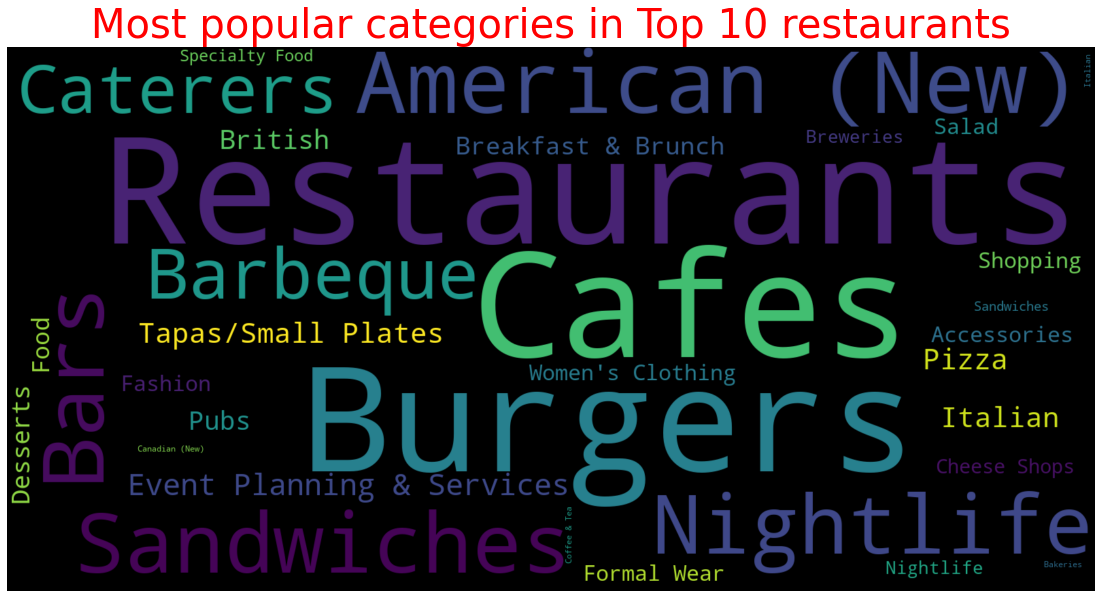

In [138]:
wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
wc.generate_from_frequencies(str_dict)
plt.figure(figsize=(20,10))
plt.title("Most popular categories in Top 10 restaurants", fontsize=40,color='red')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### As observed from the wordmap above, we see the following categories in Top 10 Restaurants by their overall rating :-  "Cafes, Burgers, American, Barbeque, Nightlife, Bars"

### Let's try to now do some recommendations for users, based on their preferences

In [139]:
n_users = data_users.user_id.unique().shape[0]
n_restaurants = data_users.business_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of Restaurants = ' + str(n_restaurants))

Number of users = 10937 | Number of Restaurants = 1411


In [140]:
df = data_users[['user_id','business_id','stars']]
df.head()

,user_id,business_id,stars
0,ZwVz20be-hOZnyAbevyMyQ,2c9Vptks_vowLgVUMnCgjw,4.0
1,91TB-gzcNyxFh46TL0pmnQ,6nKR80xEGHYf2UxAe_Cu_g,5.0
2,Y_QBiZpATJoz8hKUfYF66A,fbQaKW0Lte0JQ_opbnjdKg,5.0
3,_Jg-IA0M-GSjBlGu-wmejg,r8764MtYyt8JhxMvrfM_xQ,2.0
4,1CqkFliipv_X15WYn5aPfg,QS3QxI7u5PRdtbGgI0-UsA,4.0


In [141]:
Ratings = df.pivot_table(index = 'user_id', columns ='business_id', values = 'stars').fillna(0)
Ratings.head()

business_id,-050d_XIor1NpCuWkbIVaQ,-1UMR00eXtwaeh59pEiDjA,-4TMQnQJW1yd6NqGRDvAeA,-6h3K1hj0d4DRcZNUtHDuw,-8QlV3b_9H4BAh6LgMIr1g,-9eNGMp8XiygI8t8QFuFWw,-9nai28tnoylwViuJVrYEQ,-Bdw-5H5C4AYSMGnAvmnzw,-BxWyEIQ6wypT-37MzZizQ,-CfFjcCcGGDM9MVH_d42RQ,-F5mm0-YeCI7viSiOwVAAw,-FLnsWAa4AGEW4NgE8Fqew,-Ht7HiGBox8lS1Y8IPjO8g,-ITj6Pu8Gdw8MmLf0XBEKQ,-JwSuDqyFILFJmVpjrVbwA,-KIdCJnkt5N8rnnmWR5MQg,-Ma5JqzuI_3xIAtpNJfQ2g,-MuatiMmslPOvk9kOMyjkA,-PUPEpMsjBjk_rX5lFaWng,-RYIKWBSTaJ21B2UMyzI-Q,-ZBfr1BHvArFp1d6XH8jOQ,-bMZCfTK7fxFaURynKpBMA,-bd4BQcl1ekgo7avaFngIw,-cBQKodqi77Q0vk-9iDvQA,-hq09PjRpGcx4XXhrqh5xw,-kIscN8I29eXMPkvyyxmRQ,-o082vExIs0VVNSuZmiTQA,-oSII3bw90cvyLmgsHgmpg,-rCIoxp7pqN3xY7E3-v56Q,-raUM9T-1dKPiB5_vRmFYA,-rhH9sL3XGFpoJXcxUpEWA,-s5zZEv5u9XWhx1i5E0_pA,-s_U95xEEmJu5GK-srqpUA,-vCLrTTgw6pBufdarW8ynA,-yQHIYKXH3HAdhh1W52OMQ,01xTdrNUuTOAyH7NaRWcUA,024QUHVU7nlyW5y2BeeGLg,02EYqwh47uVxOaOKrnx8SQ,042IHd5KjHiMuBtGtugO_g,05BpxQYVbywxliQ9yA0CKw,...,y2e1DgIUBlERep7hrKz2-w,yA6dKNm_zl1ucZCnwW8ZCg,yAXWKWRTs4wNy-zrJgoeXQ,yCK1Ok69D7TSWJESZQZHiQ,yF9G4dJAm94pfnEWzPtPYQ,yFUvKpW66cNsYXD6inDsog,yLMSxHjK56Az-KtMQyG7LQ,yNPh5SO-7wr8HPpVCDPbXQ,yRvmDKX-Ocgd8zq_iMgujA,yUkOP3Tmdp1pWA7p3zHboQ,yX0pOWG_Be9TjGnm0aihVA,yXj1P-pc6CGDFSta-45L5Q,yZAGhlsrmupLbrgdKm6reg,ydqbNz2sHENV9XOElwyAYA,ydt5yifyYhF5s430llv_Hw,yet0Pww_ouW49T7V41ecSw,ylxqmxh2gO1yCpQkIk6o3A,ymtJtXwsJUClLNDepV1piQ,yqYtY3-Po4OVPafA9Z-Xyw,ytAsW7DYezxMMzqoO_-nIQ,yvwK4MO2qnSZE5ggYGyk1A,z4K95Y4P5nMrtJiDtXWDYA,z5KWNSDvgv-4I62P8l8Ynw,z6-reuC5BYf_Rth9gMBfgQ,zDyv4CoaYvAgQhgr1IK1sg,zJGtD3y-pAIGNId4codEEg,zNGYsFeG_7XEBodbtfux5Q,zOL260xaXDYZZPBItzALxQ,zS3-CKZVVvUYvasJnAg-aA,zUgDrRtGvK5ZTFlHCsTHwA,z_lDO8d8nkSmcvTjB4N69A,za9qr9ZZWLTfEgTfogRbUw,zbrFk-4ejesAJD8EwcdHxg,zfiSQ1dl3vTJ-og96eqXGA,zidkKI_N1OPxsiddTOQH_Q,zqNgwQjj0_XAll-neGikIw,zr93wrNyXzc-HW4IcK4iRQ,zrDi4gEaUi64lAMfJU51dw,zrTGcb83AsfyVTMrsCa65A,zuVvDYJkKAbXQTTBauAqJQ
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--2HUmLkcNHZp0xw6AMBPg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--4rAAfZnEIAKJE80aIiYg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--Nnm_506G_p8MxAOQna5w,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--ty7Z9fEt08E3dS3_qoSA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0IiMAZI2SsQ7VmyzJjokQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
R = Ratings.values
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

### Let's use SVD Matrix factorization to derive to the optimal features

In [143]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

#### Let's convert the sigma matrix to diagonal matrix

In [144]:
sigma = np.diag(sigma)
sigma

array([[32.22649809,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 32.27391077,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 32.4127771 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 43.41714031,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        45.73792865,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 48.49600334]])

#### Let's do a matrix multiplication with U, sigma and Vt to derive to the predicted ratings across all users for various restaurants

In [145]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

##### Let's try to get the restaurant recommendations for a specific user (userID) using the below function

In [146]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns,index=Ratings.index)
preds.head()

business_id,-050d_XIor1NpCuWkbIVaQ,-1UMR00eXtwaeh59pEiDjA,-4TMQnQJW1yd6NqGRDvAeA,-6h3K1hj0d4DRcZNUtHDuw,-8QlV3b_9H4BAh6LgMIr1g,-9eNGMp8XiygI8t8QFuFWw,-9nai28tnoylwViuJVrYEQ,-Bdw-5H5C4AYSMGnAvmnzw,-BxWyEIQ6wypT-37MzZizQ,-CfFjcCcGGDM9MVH_d42RQ,-F5mm0-YeCI7viSiOwVAAw,-FLnsWAa4AGEW4NgE8Fqew,-Ht7HiGBox8lS1Y8IPjO8g,-ITj6Pu8Gdw8MmLf0XBEKQ,-JwSuDqyFILFJmVpjrVbwA,-KIdCJnkt5N8rnnmWR5MQg,-Ma5JqzuI_3xIAtpNJfQ2g,-MuatiMmslPOvk9kOMyjkA,-PUPEpMsjBjk_rX5lFaWng,-RYIKWBSTaJ21B2UMyzI-Q,-ZBfr1BHvArFp1d6XH8jOQ,-bMZCfTK7fxFaURynKpBMA,-bd4BQcl1ekgo7avaFngIw,-cBQKodqi77Q0vk-9iDvQA,-hq09PjRpGcx4XXhrqh5xw,-kIscN8I29eXMPkvyyxmRQ,-o082vExIs0VVNSuZmiTQA,-oSII3bw90cvyLmgsHgmpg,-rCIoxp7pqN3xY7E3-v56Q,-raUM9T-1dKPiB5_vRmFYA,-rhH9sL3XGFpoJXcxUpEWA,-s5zZEv5u9XWhx1i5E0_pA,-s_U95xEEmJu5GK-srqpUA,-vCLrTTgw6pBufdarW8ynA,-yQHIYKXH3HAdhh1W52OMQ,01xTdrNUuTOAyH7NaRWcUA,024QUHVU7nlyW5y2BeeGLg,02EYqwh47uVxOaOKrnx8SQ,042IHd5KjHiMuBtGtugO_g,05BpxQYVbywxliQ9yA0CKw,...,y2e1DgIUBlERep7hrKz2-w,yA6dKNm_zl1ucZCnwW8ZCg,yAXWKWRTs4wNy-zrJgoeXQ,yCK1Ok69D7TSWJESZQZHiQ,yF9G4dJAm94pfnEWzPtPYQ,yFUvKpW66cNsYXD6inDsog,yLMSxHjK56Az-KtMQyG7LQ,yNPh5SO-7wr8HPpVCDPbXQ,yRvmDKX-Ocgd8zq_iMgujA,yUkOP3Tmdp1pWA7p3zHboQ,yX0pOWG_Be9TjGnm0aihVA,yXj1P-pc6CGDFSta-45L5Q,yZAGhlsrmupLbrgdKm6reg,ydqbNz2sHENV9XOElwyAYA,ydt5yifyYhF5s430llv_Hw,yet0Pww_ouW49T7V41ecSw,ylxqmxh2gO1yCpQkIk6o3A,ymtJtXwsJUClLNDepV1piQ,yqYtY3-Po4OVPafA9Z-Xyw,ytAsW7DYezxMMzqoO_-nIQ,yvwK4MO2qnSZE5ggYGyk1A,z4K95Y4P5nMrtJiDtXWDYA,z5KWNSDvgv-4I62P8l8Ynw,z6-reuC5BYf_Rth9gMBfgQ,zDyv4CoaYvAgQhgr1IK1sg,zJGtD3y-pAIGNId4codEEg,zNGYsFeG_7XEBodbtfux5Q,zOL260xaXDYZZPBItzALxQ,zS3-CKZVVvUYvasJnAg-aA,zUgDrRtGvK5ZTFlHCsTHwA,z_lDO8d8nkSmcvTjB4N69A,za9qr9ZZWLTfEgTfogRbUw,zbrFk-4ejesAJD8EwcdHxg,zfiSQ1dl3vTJ-og96eqXGA,zidkKI_N1OPxsiddTOQH_Q,zqNgwQjj0_XAll-neGikIw,zr93wrNyXzc-HW4IcK4iRQ,zrDi4gEaUi64lAMfJU51dw,zrTGcb83AsfyVTMrsCa65A,zuVvDYJkKAbXQTTBauAqJQ
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--2HUmLkcNHZp0xw6AMBPg,-0.110399,0.014342,0.043034,-0.060226,0.005544,0.013571,-0.016445,0.107089,0.015229,-0.003068,0.000390,-0.018252,-0.001591,-0.003179,0.002314,0.016195,0.013231,0.011517,-0.005981,0.017106,-0.046946,0.006267,0.033522,0.009360,0.012324,0.046116,-0.029531,0.020040,-0.016054,0.016927,-0.102659,-0.019870,0.010361,-0.011594,-0.056309,0.010156,-0.015879,0.031700,-0.042053,0.011406,...,0.007528,-0.007428,0.006029,-0.012119,0.020628,-0.022056,-0.089666,0.118070,0.005459,0.073735,0.021189,0.035296,0.013865,0.006565,0.004885,-0.002288,0.005871,0.059704,0.026225,-0.031818,0.007691,0.048776,0.033402,-0.031651,0.009909,0.097096,0.017900,0.010682,0.006040,0.002932,0.015637,0.002668,0.037869,0.008408,0.034538,-0.008473,0.087761,-0.011941,0.022157,-0.030585
--4rAAfZnEIAKJE80aIiYg,-0.006369,0.003531,0.000591,-0.002248,0.000242,0.006261,-0.013432,0.008403,-0.005541,0.000887,0.000987,-0.016837,-0.015904,0.007400,0.003092,0.001268,-0.000012,0.009668,0.004034,0.003226,0.013214,0.000645,0.016947,-0.000150,0.009962,-0.020561,-0.000291,0.003528,0.002650,0.002971,0.067635,0.002359,0.002588,0.005870,0.053820,0.002462,0.000095,0.006575,0.009496,0.000520,...,0.002486,0.001071,0.003805,0.004431,0.002318,0.006992,0.007483,-0.019436,0.000826,0.001860,0.006752,0.002803,-0.016508,-0.000672,0.000967,-0.001140,0.004170,-0.001469,0.005957,0.005076,0.000122,0.003421,0.015686,0.129314,0.009784,-0.022329,0.003383,0.002714,0.001883,0.002096,-0.000416,0.001699,0.005283,0.002175,0.000176,-0.001181,0.019177,0.017368,0.005389,0.006907
--Nnm_506G_p8MxAOQna5w,-0.017200,0.002145,0.011320,-0.003892,0.002699,0.008894,0.013330,-0.006617,0.010168,0.000037,0.003477,-0.008995,0.029925,0.012619,0.003146,0.003263,0.002366,0.009947,0.001179,0.003086,0.012360,0.000893,0.019105,-0.001673,0.003291,0.002854,0.010094,0.007328,-0.000857,-0.000715,-0.001169,-0.000884,0.003561,-0.004393,-0.058548,-0.000014,0.006650,0.000195,0.016915,0.007646,...,0.002278,0.002273,-0.001814,0.003192,0.003432,0.001006,-0.001156,0.138006,0.004121,0.003665,0.003784,0.004969,0.00126

In [147]:
def recommend_restaurants(predictions, userID, restaurant, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    #user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.loc[userID].sort_values(ascending=False) # User ID starts at 1
    print("Sorted User Predictions for user {0} are {1}".format(userID,sorted_user_predictions))
    #print(sorted_user_predictions)
    
    # Get the user's data and merge with the restaurant information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(restaurant,how = 'left',left_on='business_id',right_on='business_id').
                     sort_values(['stars_x'], ascending=False)
                 )

    print('User {0} has already rated {1} restaurant.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings restaurants not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rated restaurants that the user hasn't seen yet.
    recommendations = (restaurant[~restaurant['business_id'].isin(user_full['business_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index()).
         rename(columns = {userID: 'Predictions'}).
         sort_values(['Predictions'], ascending = False).
                       iloc[:num_recommendations, :]
                      )

    return user_full, recommendations

Let's checkout the recommendations for the user with userID "d_TBs6J3twMy9GChqUEXkg"

In [148]:
already_rated, predictions = recommend_restaurants(preds,"d_TBs6J3twMy9GChqUEXkg", data_restaurant, data_users, 10)

Sorted User Predictions for user d_TBs6J3twMy9GChqUEXkg are business_id
NJ0RzuWd5xDqfJejYQZ65g    8.304328
7mGZrCzGGjS95SdRtEaGcQ    6.782879
7m1Oa1VYV98UUuo_6i0EZg    5.919437
N5B7OBTyNGgwU_Y2fwNcyw    5.887064
J07TDs6qnTIaxm48EL1cKQ    5.751010
                            ...   
_DPJ_PHJnXsuhYhsgBA0Xw   -0.710476
jsuUmIEefPjV__ads62Z5w   -0.751174
Tw3miGKZHtmxmaQZIYFRrA   -0.782230
fbQaKW0Lte0JQ_opbnjdKg   -0.793906
C8D_GU9cDDjbOJfCaGXxDQ   -0.937200
Name: d_TBs6J3twMy9GChqUEXkg, Length: 1411, dtype: float64
User d_TBs6J3twMy9GChqUEXkg has already rated 63 restaurant.
Recommending highest 10 predicted ratings restaurants not already rated.


### Below are the set of Top 10 recommended restaurants based on the user similarity :

In [149]:
predictions

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Predictions
1036,XC06xxb7FFYsXcI2E38IIw,Hillstone Restaurant,2650 E Camelback Rd,Phoenix,AZ,85016,33.510143,-112.024303,4.0,701,1,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Arts & Entertainment, Steakhouses, Jazz & Blue...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1.112513
528,-ZBfr1BHvArFp1d6XH8jOQ,Rocket Burger & Subs,12038 N 35th Ave,Phoenix,AZ,85029,33.595836,-112.134591,4.5,761,1,"{'DriveThru': 'False', 'BusinessParking': ""{'g...","Restaurants, Sandwiches, Burgers, Salad, Hot Dogs","{'Monday': '10:0-18:0', 'Tuesday': '10:0-21:0'...",1.107430
1189,JQYkVnUzS5vgFxZgCuW7ag,Thai E-San,616 W Indian School Rd,Phoenix,AZ,85013,33.495155,-112.082213,4.5,586,1,"{'RestaurantsAttire': ""u'casual'"", 'GoodForKid...","Food, Buffets, Beer, Wine & Spirits, Thai, Res...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:30',...",0.945599
1265,szhJLmdLDVFTevm8fu0T4A,Great Wall Cuisine,"3446 W Camelback Rd, Ste 155",Phoenix,AZ,85017,33.510988,-112.133277,3.5,465,1,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Cantonese, Dim Sum, Chinese, Restaurants","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",0.894837
872,h6Y1-KfN2XBkcrV85CS8yg,Studio Movie Grill,15515 N Hayden Rd,Scottsdale,AZ,85260,33.627304,-111.894767,3.0,748,1,"{'CoatCheck': 'False', 'BusinessParking': ""{'g...","American (Traditional), Bars, Nightlife, Ameri...",NaN,0.875089
1106,Jj8ubiwwuCR-rrhrrjcryw,Da Vang Restaurant,4538 N 19th Ave,Phoenix,AZ,85015,33.503776,-112.100501,4.0,627,1,"{'RestaurantsTableService': 'True', 'Corkage':...","Vietnamese, Restaurants","{'Monday': '8:0-20:0', 'Tuesday': '8:0-20:0', ...",0.830528
65,yNPh5SO-7wr8HPpVCDPbXQ,The Arrogant Butcher,"2 E Jefferson St, Ste 150",Phoenix,AZ,85004,33.447392,-112.072831,4.0,1972,1,"{'NoiseLevel': ""u'average'"", 'Ambience': ""{'ro...","American (New), American (Traditional), Bars, ...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...",0.827301
451,cTZmf7B-4yciMc1WKiCVOA,Welcome Diner,929 E Pierce St,Phoenix,AZ,85006,33.455532,-112.060713,4.5,905,1,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Burgers, Soul Food, Restaurants, American (Tra...","{'Monday': '17:0-2:0', 'Tuesday': '17:0-2:0', ...",0.797580
965,zJGtD3y-pAIGNId4codEEg,Otro Cafe,6035 N 7th St,Phoenix,AZ,85014,33.525339,-112.064488,4.0,690,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Cafes, Mexican","{'Monday': '0:0-0:0', 'Tuesday': '17:0-22:0', ...",0.737494
1223,ms7cmWkPiSBDTnz-1sv2kQ,Ticoz Latin Kitchen,5114 N 7th St,Phoenix,AZ,85014,33.511678,-112.065342,4.0,455,0,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Caribbean, Restaurants, Mexican, Latin American","{'Tuesday': '11:0-22:0', 'Wednesday': '11:0-22...",0.658510


### Model evaluation

In [150]:
!pip install surprise

In [151]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD#, evaluate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(data_users[['user_id', 'business_id', 'stars']], reader)

In [152]:
!pip install surprise

In [153]:
from surprise.model_selection import cross_validate

svd = SVD()

# Compute the RMSE of the SVD algorithm.
cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1183  1.1193  1.1123  1.1134  1.1017  1.1130  0.0063  
Fit time          1.31    1.33    1.32    1.30    1.29    1.31    0.01    
Test time         0.03    0.04    0.03    0.04    0.04    0.04    0.00    


{'fit_time': (1.3097176551818848,
  1.3290867805480957,
  1.316955804824829,
  1.2955327033996582,
  1.2905068397521973),
 'test_rmse': array([1.11833108, 1.11929101, 1.1122844 , 1.11343342, 1.10173824]),
 'test_time': (0.03474903106689453,
  0.04138350486755371,
  0.03488612174987793,
  0.040084123611450195,
  0.03932356834411621)}

### Overall RMSE value is ~1.1, which seems to be pretty fine.

## Let's also try something different by recommending users based on their preference

In [154]:
rest_data = data_users[['business_id', 'user_id', 'stars', 'text']]
rest_data

,business_id,user_id,stars,text
0,2c9Vptks_vowLgVUMnCgjw,ZwVz20be-hOZnyAbevyMyQ,4.0,Came here while in town for a country concert....
1,6nKR80xEGHYf2UxAe_Cu_g,91TB-gzcNyxFh46TL0pmnQ,5.0,Best barbecue this side of the Mississippi!!!!...
2,fbQaKW0Lte0JQ_opbnjdKg,Y_QBiZpATJoz8hKUfYF66A,5.0,Absolutely amazing. Think Chipotle for enchila...
3,r8764MtYyt8JhxMvrfM_xQ,_Jg-IA0M-GSjBlGu-wmejg,2.0,I was really disappointed with my most recent ...
4,QS3QxI7u5PRdtbGgI0-UsA,1CqkFliipv_X15WYn5aPfg,4.0,I grade sushi restaurants on 3 factors:\n- Qua...
...,...,...,...,...
26601,8nNB_yG1gzVpbqNH2EBucg,iDlkZO2iILS8Jwfdy7DP9A,3.0,Met a friend here for lunch. It was not as pa...
26602,R-sEoZXf37pGzLnid7s6wA,5monCcK5b_sRvUpOk0H1Sw,5.0,Love this place! One of the best local Mexican...
26603,SurnOSM2bVVN4-Js3G23RQ,llXWc7py2mDQwZrNrogSDg,4.0,I like the unique atmosphere of this place. bu...
26604,ms7cmWkPiSBDTnz-1sv2kQ,mRaaWyAFSwYGOT40T1-T9Q,2.0,"Oh Ticoz, I have been through a lot with you. ..."


In [155]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

for word in stopwords.words('english'):
    print(word)

import string
print(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
i
me
my
myself
we
our
ours
ourselves
you
you're
you've
you'll
you'd
your
yours
yourself
yourselves
he
him
his
himself
she
she's
her
hers
herself
it
it's
its
itself
they
them
their
theirs
themselves
what
which
who
whom
this
that
that'll
these
those
am
is
are
was
were
be
been
being
have
has
had
having
do
does
did
doing
a
an
the
and
but
if
or
because
as
until
while
of
at
by
for
with
about
against
between
into
through
during
before
after
above
below
to
from
up
down
in
out
on
off
over
under
again
further
then
once
here
there
when
where
why
how
all
any
both
each
few
more
most
other
some
such
no
nor
not
only
own
same
so
than
too
very
s
t
can
will
just
don
don't
should
should've
now
d
ll
m
o
re
ve
y
ain
aren
aren't
couldn
couldn't
didn
didn't
doesn
doesn't
hadn
hadn't
hasn
hasn't
haven
haven't
isn
isn't
ma
mightn
mightn't
mustn
mustn't
needn
needn't
shan
shan't
shouldn
shouldn

In [156]:
def clean_stop_and_punct(data):
    nopunc = [char for char in data if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return " ".join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [157]:
rest_data['text'] = rest_data['text'].apply(clean_stop_and_punct)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [158]:
X_train, X_test, y_train, y_test = train_test_split(rest_data['text'], data_users['business_id'], test_size = 0.2)

In [159]:
user_df = rest_data[['user_id','text']]
business_df = rest_data[['business_id', 'text']]

In [160]:
user_df = user_df.groupby('user_id').agg({'text': ' '.join})
business_df = business_df.groupby('business_id').agg({'text': ' '.join})

In [161]:
#userid vectorizer
user_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
user_vectors = user_vectorizer.fit_transform(user_df['text'])
user_vectors.shape

(10937, 5000)

In [162]:
business_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
business_vectors = business_vectorizer.fit_transform(business_df['text'])
business_vectors.shape

(1411, 5000)

In [163]:
user_rating_matrix = pd.pivot_table(rest_data, values='stars', index=['user_id'], columns=['business_id'])
user_rating_matrix.shape

(10937, 1411)

In [164]:
P = pd.DataFrame(user_vectors.toarray(), index=user_df.index, columns=user_vectorizer.get_feature_names())
Q = pd.DataFrame(business_vectors.toarray(), index=business_df.index, columns=business_vectorizer.get_feature_names())

In [165]:
P.head()

,0,1,10,100,1000,101,1015,1030,10pm,11,110,1100,11am,12,13,14,15,150,1520,16,16th,17,18,19,1st,2,20,200,2030,21,22,23,24,25,250,26,27,2nd,2pm,3,...,yea,yeah,year,years,yell,yelling,yellow,yellowtail,yelp,yelper,yelpers,yep,yes,yesterday,yet,yikes,yo,yogurt,york,yorker,youd,youll,young,younger,youre,youve,yuck,yum,yummy,yup,z,zero,zest,zinburger,zinc,zipps,ziti,zookz,ztejas,zucchini
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--2HUmLkcNHZp0xw6AMBPg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--4rAAfZnEIAKJE80aIiYg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--Nnm_506G_p8MxAOQna5w,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.123503,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--ty7Z9fEt08E3dS3_qoSA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.189174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.138123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0IiMAZI2SsQ7VmyzJjokQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.060124,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
Q.head()

,0,1,10,100,1000,101,1015,1030,10pm,11,110,1100,11am,12,13,14,15,150,1520,16,16th,17,18,19,1st,2,20,200,2030,21,22,23,24,25,250,26,27,2nd,2pm,3,...,yea,yeah,year,years,yell,yelling,yellow,yellowtail,yelp,yelper,yelpers,yep,yes,yesterday,yet,yikes,yo,yogurt,york,yorker,youd,youll,young,younger,youre,youve,yuck,yum,yummy,yup,z,zero,zest,zinburger,zinc,zipps,ziti,zookz,ztejas,zucchini
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-050d_XIor1NpCuWkbIVaQ,0.0,0.008207,0.007553,0.018681,0.0,0.0,0.0,0.01092,0.0,0.0,0.0,0.011084,0.0,0.0,0.0,0.0,0.009181,0.0,0.009917,0.0,0.0,0.0,0.0,0.0,0.015608,0.009481,0.008771,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.02917,0.0,0.0,0.0,0.0,0.006462,...,0.0,0.018264,0.004863,0.003854,0.0,0.0,0.0,0.0,0.008796,0.0,0.00721,0.0,0.025277,0.0,0.012467,0.0,0.0,0.0,0.007746,0.0,0.006729,0.005029,0.0,0.0,0.006845,0.006305,0.0,0.009809,0.023872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1UMR00eXtwaeh59pEiDjA,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.038465,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.150665,0.00000,0.0,0.0,0.0,0.0,0.039327,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4TMQnQJW1yd6NqGRDvAeA,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.031204,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.027033,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.021961,0.000000,0.0,0.000000,0.025530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-6h3K1hj0d4DRcZNUtHDuw,0.0,0.028830,0.026530,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.016125,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.055504,0.015404,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.056747,...,0.0,0.021385,0.000000,0.040611,0.0,0.0,0.0,0.0,0.030897,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.012022,0.000000,0.0,0.017228,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8QlV3b_9H4BAh6LgMIr1g,0.0,0.000000,0.017124,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.018844,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
# With SGD algo below, we are trying to get the best features, which would reduce the overall RMSE to as minimal as possible.
def Stochastic_GD(R, P, Q, steps=5, gamma=0.001,lamda=0.02):
    for step in range(steps):
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0: # start doing this, only for those entries, where the ratings are filled by users. Sparse Matrix!!!
                    eij=R.loc[i,j]-np.dot(P.loc[i],Q.loc[j])
                    #Updating the values of P & Q, such that the eij or cost function and hence error is reducing!!
                    #Basically we are calculating derivative of eij(error) w.r.t P first and then Q in the below 2 equations
                    #reference (Slide 37) :- https://www.cs.cmu.edu/~mgormley/courses/10601-s17/slides/lecture25-mf.pdf  
                    P.loc[i]=P.loc[i]+gamma*(eij*Q.loc[j]-lamda*P.loc[i])
                    Q.loc[j]=Q.loc[j]+gamma*(eij*P.loc[i]-lamda*Q.loc[j])
        e=0
        ## Now that we have figured out the best set of paramters/Factors that can lead to minimum error using SGD, 
        ## we can now calc the right error/RMSE using regularization parameters for P & Q
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    e= e + pow(R.loc[i,j]-np.dot(P.loc[i],Q.loc[j]),2)+lamda*(pow(np.linalg.norm(P.loc[i]),2)+pow(np.linalg.norm(Q.loc[j]),2))
        if e<0.001:
            break
        
    return P,Q

### <b><u><i> Please be mindful while running the below command as it takes a huge time ~45mins on my laptop with steps=5 and took around 35mins on Google colab </b></u></i>

In [168]:
%%time
P, Q = Stochastic_GD(user_rating_matrix, P, Q, steps=5, gamma=0.001,lamda=0.02)

CPU times: user 32min 6s, sys: 766 ms, total: 32min 7s
Wall time: 32min 9s


In [169]:
# Store P, Q and vectorizer in pickle file
import pickle
#output = open('rest_recommendation_model.pkl', 'wb')
#pickle.dump(P,output)
#pickle.dump(Q,output)
#pickle.dump(user_vectorizer,output)
#output.close()

### Change the text below to get the recommendations as per your preference 

In [170]:
words = "Italian restaurants"
#Now, convert the text to DataFrame
test_df= pd.DataFrame([words], columns=['text'])
#Clean the text received from Punctuations and English stop words
test_df['text'] = test_df['text'].apply(clean_stop_and_punct)
#Transform the text to tfidf vectors
#load_vectorizer=pickle.load(open('rest_recommendation_model.pkl', 'rb'))
#test_vectors = load_vectorizer.transform(test_df['text'])
test_vectors=user_vectorizer.transform(test_df['text'])
print(test_vectors.shape)
#Convert the vectors to Dataframe as shown below
test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=user_vectorizer.get_feature_names())

print(test_v_df)
#Now predict the Restaurant rating by doing a MATMUL with our text features with restaurant features
#Basically we are trying to get the similarity w.r.t restaurants using and comparing the text features of other restaurants to find similarity
predictItemRating=pd.DataFrame(np.dot(test_v_df.loc[0],Q.T),index=Q.index,columns=['Rating'])
print(predictItemRating)
#Out of all predicted data, lets pick up the top 10 restaurants
topRecommendations=pd.DataFrame.sort_values(predictItemRating,['Rating'],ascending=[0])[:7]
print("These are top recommendations : ")
print("#######################################")
print(topRecommendations)
print("#######################################")
for i in topRecommendations.index:
    print(data_restaurant[data_restaurant['business_id']==i]['name'].iloc[0])
    print(data_restaurant[data_restaurant['business_id']==i]['categories'].iloc[0])
    print(str(data_restaurant[data_restaurant['business_id']==i]['stars'].iloc[0])+ ' '+str(data_restaurant[data_restaurant['business_id']==i]['review_count'].iloc[0]))
    print('')

(1, 5000)
     0    1   10  100  1000  101  ...  zinc  zipps  ziti  zookz  ztejas  zucchini
0  0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0    0.0   0.0    0.0     0.0       0.0

[1 rows x 5000 columns]
                          Rating
business_id                     
-050d_XIor1NpCuWkbIVaQ  0.017430
-1UMR00eXtwaeh59pEiDjA  0.000905
-4TMQnQJW1yd6NqGRDvAeA  0.036451
-6h3K1hj0d4DRcZNUtHDuw  0.086186
-8QlV3b_9H4BAh6LgMIr1g  0.026132
...                          ...
zqNgwQjj0_XAll-neGikIw  0.001829
zr93wrNyXzc-HW4IcK4iRQ  0.021465
zrDi4gEaUi64lAMfJU51dw  0.013218
zrTGcb83AsfyVTMrsCa65A  0.010128
zuVvDYJkKAbXQTTBauAqJQ  0.003865

[1411 rows x 1 columns]
These are top recommendations : 
#######################################
                          Rating
business_id                     
yFUvKpW66cNsYXD6inDsog  0.465426
G8vA6pq4p8KslaURm-q65Q  0.421289
r5PLDU-4mSbde5XekTXSCA  0.366221
VeRHiEbUe_vHprYn8mnezA  0.362723
SWhHaWFuijy_KDs0zVCJog  0.349687
2Zeh89IUg7T4dUFjRfqtdg  0.342285
zUgDrRtGvK